# Reconstructing Sound with Nifty
### Vincent Eberle, Philipp Zehetner

- We downloaded a short sound file, played it with laptop speakers and recorded it with a smartphone microphone. 
- The resulting audio file is noisy and of bad quality. 
- We tried to reconstruct the original sound as good as possible using a __critical filter__ with _NIFTy_

For Context: 
[Extract from 'The Simpsons Movie' (German Version)](https://www.youtube.com/watch?v=TBLy3SVPNJI)

In [1]:
from IPython.display import Audio

Original_Audio = Audio("Data/CutShort32/Arnold_Arnold.wav")
Phone_Recording_P = Audio("Data/CutShort32/Arnold_mobile1.wav")
Phone_Recording_V = Audio("Data/CutShort32/Arnold_mobile2.wav")

In [2]:
Original_Audio

In [3]:
Phone_Recording_P

In [4]:
Phone_Recording_V

## 1. Importing Audio

- We are using .wav files as they can be easily turned into numpy arrays
- Different versions of .wav files use different data types (```uint8``` up to ```int32``` as well as ```float32```) and some audio programs automatically transform them. 
- _NIFTy_ doesn't like integers in fields. 
- Fourier Transformations in _NIFTy_ return ```float64``` which won't work as .wav file


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import nifty5 as ift
from scipy.io.wavfile import read, write
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

Testing = False

# Loading input files
signal_rate, signal_sound = read('Data/CutShort32/Arnold_Arnold.wav')
vincent_rate, vincent_sound = read('Data/CutShort32/Arnold_mobile1.wav')
philipp_rate, philipp_sound = read('Data/CutShort32/Arnold_mobile2.wav')
signal_sound = np.array(signal_sound, np.float32)
vincent_sound = np.array(vincent_sound, np.float32)
philipp_sound = np.array(philipp_sound, np.float32)

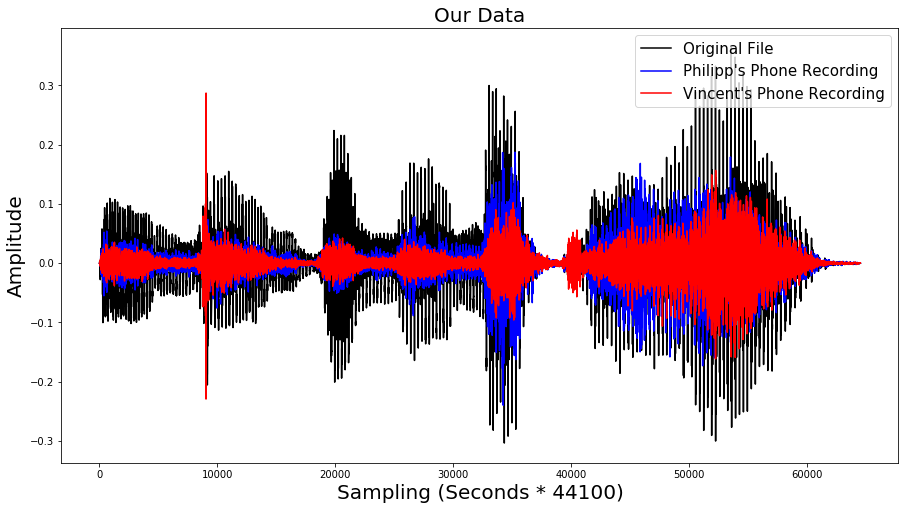

In [6]:
plt.figure(figsize=(15, 8))
plt.title('Our Data', fontsize=20)
plt.plot(signal_sound, label='Original File', c='black')
plt.plot(philipp_sound, label="Philipp's Phone Recording", c='blue')
plt.plot(vincent_sound, label="Vincent's Phone Recording", c='red')
plt.ylabel('Amplitude', fontsize=20)
plt.xlabel('Sampling (Seconds * 44100)', fontsize=20)
plt.legend(fontsize=15, loc='upper right')
plt.show()
plt.savefig('Arnold.png', dpi=300)
plt.close()

In [7]:
# Define Spaces (time, harmonic & data)
time_space = ift.RGSpace([len(signal_sound)])
harmonic_space = time_space.get_default_codomain()
R = ift.GeometryRemover(time_space)
data_space = R.target
power_space = ift.PowerSpace(harmonic_space)

## 2. Critical Filter
Our implementation follows the critical filter and we try to infer the power spectrum. To do this, we have to define all the necessary _NIFTy_ spaces and fields as well as the ```SLAmplitude``` operator

In [8]:
# We want to learn the power spectrum
A = ift.SLAmplitude(
        ## Amplitude = sqrt(PowerSpectrum)
        ## SL = Smooth & Linear
    **{
        'target': power_space,
        'n_pix': 64,  # 64 spectral bins, in practice this can be left at 64 in most cases
        # Smoothness of spectrum
        'a': 20,  # relatively high variance of spectral curvature
        'k0': .5,  # quefrency mode below which cepstrum flattens
        # Power-law part of spectrum
        # These parameters describe the linear (on double log scale) behaviour of the power spectrum
        'sm': -.5,  # preferred power-law slope
        'sv': 1.,  # low variance of power-law slope
        'im': -27,  # y-intercept mean, in-/decrease for more/less contrast
        'iv': 4.  # y-intercept variance
    })

B = ift.SLAmplitude(
        ## Amplitude = sqrt(PowerSpectrum)
        ## SL = Smooth & Linear
    **{
        'target': power_space,
        'n_pix': 64,  # 64 spectral bins, in practice this can be left at 64 in most cases
        # Smoothness of spectrum
        'a': 10,  # relatively high variance of spectral curvature
        'k0': 0.2,  # quefrency mode below which cepstrum flattens
        # Power-law part of spectrum
        # These parameters describe the linear (on double log scale) behaviour of the power spectrum
        'sm': -4,  # preferred power-law slope
        'sv': 0.6,  # low variance of power-law slope
        'im': -2,  # y-intercept mean, in-/decrease for more/less contrast
        'iv': 2.  # y-intercept variance
    })

In [9]:
# Define Data and Signal and give a prior for noise
ground_truth = ift.from_global_data(time_space, signal_sound)
data = ift.from_global_data(data_space, vincent_sound)
plot_data = ift.from_global_data(time_space, vincent_sound) #This is only for plotting
N = ift.ScalingOperator(0.0001, data_space)

signal = ift.CorrelatedField(time_space, A)
signal_response = R @ signal
bad_signal = ift.CorrelatedField(time_space, B)
bad_signal_response = R @ bad_signal

# Define Fourier Transformation
HT = ift.HartleyOperator(time_space, target=harmonic_space)
signal_frequency = HT(ground_truth)
power_signal = ift.power_analyze(signal_frequency)
data_frequency = HT(plot_data)
power_data = ift.power_analyze(data_frequency)

# We now try to infere the power spectrum
likelihood = ift.GaussianEnergy(mean=data, inverse_covariance=N.inverse) @ signal_response   

## 3. Deciding on the prior values for A

- Using the initial values for ```SLAmplitude``` the y-intercept is off by 14 orders of magnitude
- We draw random samples and adjust the parameters to get a prior spectrum that is close to our data

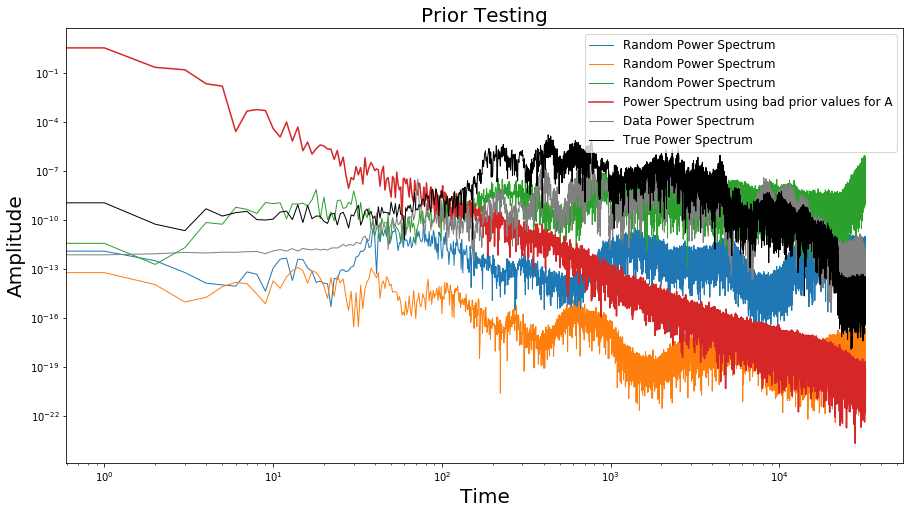

In [10]:
# Plotting
plt.figure(figsize=(15, 8))
plt.title('Prior Testing', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Amplitude', fontsize=20)
plt.xlabel('Time', fontsize=20)

for i in range(3) : 
    p = ift.from_random('normal', signal.domain)
    p = signal(p)
    p = ift.power_analyze(HT(p))
    plt.plot(p.to_global_data(), label='Random Power Spectrum', lw=1)

p = ift.from_random('normal', bad_signal.domain)
p = bad_signal(p)
p = ift.power_analyze(HT(p))
plt.plot(p.to_global_data(), label='Power Spectrum using bad prior values for A')

plt.plot(power_data.to_global_data(), label='Data Power Spectrum', c='grey', lw=1)
plt.plot(power_signal.to_global_data(), label='True Power Spectrum', c='black',lw=1)
plt.legend(fontsize=12, loc='upper right')
plt.show()
plt.savefig('Spectrum.png', dpi=300)
plt.close()

## 4. Minimizing the KL

In [11]:
# Numerics Stuff
if Testing : N_it = 5
else : N_it = 20
ic_sampling = ift.GradientNormController(iteration_limit=N_it)
ic_newton = ift.GradInfNormController(name='Newton', tol=1e-10, iteration_limit=N_it)
minimizer = ift.NewtonCG(ic_newton)

ham = ift.StandardHamiltonian(likelihood, ic_sampling)
mean = 0.01 * ift.from_random('normal', ham.domain)

for _ in range(20): 
    KL = ift.MetricGaussianKL(mean, ham, 5)
    KL, _ = minimizer(KL)
    mean = KL.position

KL = ift.MetricGaussianKL(mean, ham, 30)

Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Newton: Iteration #0 energy=1.750226E+05 crit=7.51E+00 clvl=0
Newton: Iteration #1 energy=1.739086E+05 crit=3.73E-01 clvl=0
Newton: Iteration #2 energy=1.682296E+05 crit=5.23E-02 clvl=0
Newton: Iteration #3 energy=1.598516E+05 crit=2.42E-02 clvl=0
Newton: Iteration #4 energy=1.541365E+05 crit=5.87E-02 clvl=0
Newton: Iteration #5 energy=1.523830E+05 crit=2.88E-02 clvl=0
Newton: Iteration #6 energy=1.481129E+05 crit=5.32E-02 clvl=0
Newton: Iteration #7 energy=1.480200E+05 crit=4.36E-03 clvl=0
Newton: Iteration #8 energy=1.446804E+05 crit=7.34E-03 clvl=0
Newton: Iteration #9 energy=1.442141E+05 crit=1.03E-02 clvl=0
Newton: Iteration #10 energy=1.433974E+05 crit=5.46E-03 clvl=0
Newton: Iteration #11 energy=1.417138E+05 crit=7.81E-02 clvl=0
Newton: Iteration #12 en

Newton: Iteration #0 energy=6.198277E+04 crit=5.19E-01 clvl=0
Newton: Iteration #1 energy=6.157199E+04 crit=4.56E-02 clvl=0
Newton: Iteration #2 energy=5.130353E+04 crit=1.13E+00 clvl=0
Newton: Iteration #3 energy=5.092678E+04 crit=1.99E-02 clvl=0
Newton: Iteration #4 energy=4.925701E+04 crit=5.12E-02 clvl=0
Newton: Iteration #5 energy=4.744415E+04 crit=1.12E-01 clvl=0
Newton: Iteration #6 energy=4.724180E+04 crit=1.77E-02 clvl=0
Newton: Iteration #7 energy=4.636197E+04 crit=2.20E-02 clvl=0
Newton: Iteration #8 energy=4.619506E+04 crit=1.31E-03 clvl=0
Newton: Iteration #9 energy=4.607632E+04 crit=5.91E-03 clvl=0
Newton: Iteration #10 energy=4.604403E+04 crit=5.03E-03 clvl=0
Newton: Iteration #11 energy=4.603752E+04 crit=7.74E-04 clvl=0
Newton: Iteration #12 energy=4.602582E+04 crit=2.33E-03 clvl=0
Newton: Iteration #13 energy=4.602440E+04 crit=5.53E-04 clvl=0
Newton: Iteration #14 energy=4.602406E+04 crit=1.26E-05 clvl=0
Newton: Iteration #15 energy=4.602391E+04 crit=1.25E-04 clvl=0
Ne

Newton: Iteration #4 energy=4.706739E+04 crit=2.93E-02 clvl=0
Newton: Iteration #5 energy=4.489833E+04 crit=2.29E-02 clvl=0
Newton: Iteration #6 energy=4.414215E+04 crit=4.89E-02 clvl=0
Newton: Iteration #7 energy=4.400055E+04 crit=2.61E-03 clvl=0
Newton: Iteration #8 energy=4.380619E+04 crit=7.73E-03 clvl=0
Newton: Iteration #9 energy=4.375716E+04 crit=2.52E-03 clvl=0
Newton: Iteration #10 energy=4.374309E+04 crit=4.91E-03 clvl=0
Newton: Iteration #11 energy=4.373916E+04 crit=7.46E-05 clvl=0
Newton: Iteration #12 energy=4.373636E+04 crit=2.41E-04 clvl=0
Newton: Iteration #13 energy=4.373391E+04 crit=7.39E-05 clvl=0
Newton: Iteration #14 energy=4.373298E+04 crit=6.61E-05 clvl=0
Newton: Iteration #15 energy=4.373289E+04 crit=5.19E-05 clvl=0
Newton: Iteration #16 energy=4.373267E+04 crit=4.27E-05 clvl=0
Newton: Iteration #17 energy=4.373259E+04 crit=3.69E-05 clvl=0
Newton: Iteration #18 energy=4.373259E+04 crit=2.17E-06 clvl=0
Newton: Iteration #19 energy=4.373259E+04 crit=2.38E-05 clvl=

Newton: Iteration #8 energy=4.517237E+04 crit=2.44E-03 clvl=0
Newton: Iteration #9 energy=4.510224E+04 crit=1.01E-02 clvl=0
Newton: Iteration #10 energy=4.508446E+04 crit=1.85E-03 clvl=0
Newton: Iteration #11 energy=4.507790E+04 crit=8.66E-03 clvl=0
Newton: Iteration #12 energy=4.507778E+04 crit=1.73E-04 clvl=0
Newton: Iteration #13 energy=4.507565E+04 crit=1.11E-03 clvl=0
Newton: Iteration #14 energy=4.507440E+04 crit=1.23E-03 clvl=0
Newton: Iteration #15 energy=4.507410E+04 crit=1.43E-04 clvl=0
Newton: Iteration #16 energy=4.507392E+04 crit=1.09E-04 clvl=0
Newton: Iteration #17 energy=4.507375E+04 crit=5.46E-05 clvl=0
Newton: Iteration #18 energy=4.507367E+04 crit=6.65E-05 clvl=0
Newton: Iteration #19 energy=4.507364E+04 crit=5.71E-05 clvl=0
Newton: Iteration #20 energy=4.507361E+04 crit=5.43E-05 clvl=0
Newton:  Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming co

Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence


In [12]:
# Save output as .wav file
reconstructed_sound = signal(mean).to_global_data()
reconstructed_sound = np.array(reconstructed_sound , np.float32)
write('Arnold_reconstruction.wav', 44100, reconstructed_sound)

## 5. Final Result

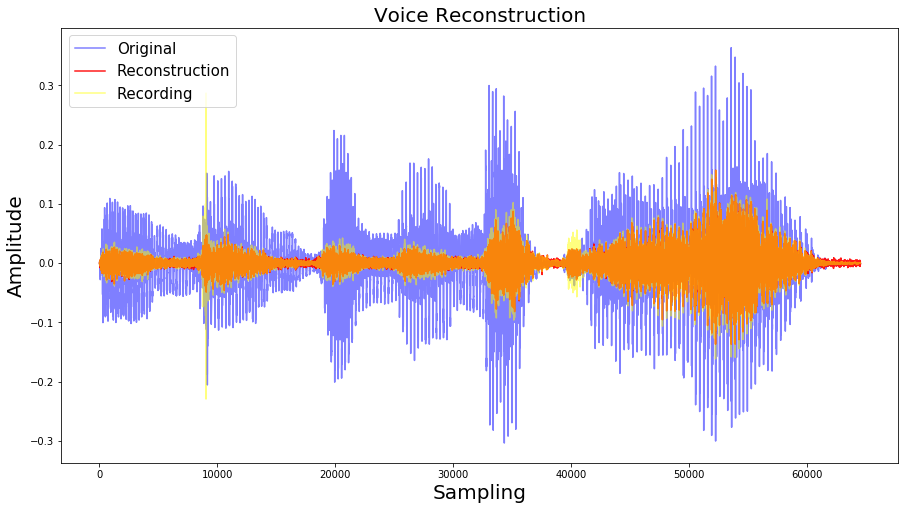

In [13]:
# Plotting
plt.figure(figsize=(15, 8))
plt.title('Voice Reconstruction', fontsize=20)
plt.plot(signal_sound, label='Original', alpha=0.5, c='b')
plt.plot(reconstructed_sound, label='Reconstruction', alpha=0.9, c='red')
plt.plot(vincent_sound, label='Recording', alpha=0.5, c='yellow')
plt.ylabel('Amplitude', fontsize=20)
plt.xlabel('Sampling', fontsize=20)
plt.legend(fontsize=15)
plt.show()
plt.savefig('Arnold.png', dpi=300)
plt.close()

In [14]:
Phone_Recording_V

In [15]:
Reconstruction = Audio('Arnold_reconstruction.wav')
Reconstruction

In [16]:
Original_Audio